<a href="https://colab.research.google.com/github/MominKhattar/Biscuit_Anomaly-Detection_Project/blob/main/Momin_Biscuit_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Setup: Mount Google Drive and Unzip the Dataset
First, we mount Google Drive to access the dataset and unzip it. The dataset IndustryBiscuit.zip contains the biscuit images and an annotation CSV (AnotaceFinal.csv). We unzip the archive into the Colab workspace.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Corrected path to the zip file on Google Drive
zip_path = '/content/drive/MyDrive/MyProjects/Biscuit_Project/IndustryBiscuit.zip'

# Unzip into a folder named 'IndustryBiscuit' in the workspace
!unzip -q "{zip_path}" -d "/content/IndustryBiscuit"

# List extracted files/folders
!ls /content/IndustryBiscuit

Mounted at /content/drive
IndustryBiscuit


#2. Load Annotations and Prepare Dataset
We read the annotation CSV to get image file names, class labels (licenceCode), and defect bounding-box coordinates. We then organize the data for both tasks:
For classification: Create folders for each class (normal, not_complete, foreign_object, color_defect) and copy images accordingly.
For segmentation: Generate binary masks from bounding boxes (defect = 1, background = 0) for each image.

In [ ]:
import pandas as pd
import os
import shutil
from PIL import Image, ImageDraw

# Path to annotation CSV inside unzipped folder
csv_path = '/content/IndustryBiscuit/IndustryBiscuit/AnotaceFinal.csv'
df = pd.read_csv(csv_path)
print(df.head())


       file  upperLeftX  upperLeftY  upperRightX  upperRightY  lowerRightX  \
0  0001.jpg    184.1447     96.4265     480.3775      96.4265     480.3775   
1  0002.jpg    183.4096     55.9977     457.5904      55.9977     457.5904   
2  0003.jpg    115.7833     82.4602     460.5306      82.4602     460.5306   
3  0004.jpg    180.4694     94.9564     447.2994      94.9564     447.2994   
4  0005.jpg    145.9211     45.7067     420.8369      45.7067     420.8369   

   lowerRightY  lowerLeftX  lowerLeftY     licenceCode  Var11  
0     408.8308    184.1447    408.8308  Vada_Neuplnost      1  
1     397.0697    183.4096    397.0697  Vada_Neuplnost      1  
2     357.3760    115.7833    357.3760  Vada_Neuplnost      1  
3     437.4985    180.4694    437.4985  Vada_Neuplnost      1  
4     392.6593    145.9211    392.6593  Vada_Neuplnost      1  


This shows columns like file, licenceCode, x_min, y_min, x_max, y_max. We map numeric licenceCode to text labels:

In [ ]:
# Define label mapping (example mapping; adjust according to actual CSV values)
label_map = {
    'Bez_Vady': 'normal',
    'Vada_Neuplnost': 'not_complete',
    'Vada_CiziObjekt': 'foreign_object',
    'Vada_NestandardniBarva': 'color_defect'
}
df['label'] = df['licenceCode'].map(label_map)

# Preview distribution of classes
print(df['label'].value_counts())


label
normal            1896
not_complete      1860
foreign_object     632
color_defect       512
Name: count, dtype: int64


We create directories for classification (if not exist) and copy images into class subfolders. This will be used by Keras's ImageDataGenerator.

In [ ]:
# Source image directory
src_dir = '/content/IndustryBiscuit/IndustryBiscuit/Images'
# Destination root for organized dataset
dst_root = '/content/biscuit_classes'

os.makedirs(dst_root, exist_ok=True)
for label in label_map.values():
    os.makedirs(os.path.join(dst_root, label), exist_ok=True)

# Copy each image to the folder of its class
for _, row in df.iterrows():
    filename = row['file']
    label = row['label']
    src_path = os.path.join(src_dir, filename)
    dst_path = os.path.join(dst_root, label, filename)
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)

#3. Method 1: Custom CNN Classifier


#3.1 Data Preparation and Augmentation
We use Keras ImageDataGenerator to load images and apply real-time data augmentation (random flips, rotations, etc.) to improve generalization
blog.keras.io
. We rescale pixel values to [0,1] and set aside a validation split.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% for validation
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    dst_root,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    dst_root,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 3921 images belonging to 4 classes.
Found 979 images belonging to 4 classes.


#3.2 Building the CNN Model
We construct a custom CNN with several convolutional and pooling layers, followed by fully-connected layers. No pre-trained backbone is used; the architecture is designed from scratch to meet professor requirements. Convolutional Neural Networks (CNNs) automatically learn hierarchical features from images
developers.google.com
blog.keras.io
.

In [ ]:
from tensorflow.keras import layers, models

num_classes = len(label_map)

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(*img_size, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

We compile the model with categorical cross-entropy loss and an optimizer (Adam).
python
Copy
Edit


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#3.3 Training the CNN
Train the CNN on the augmented data. We monitor validation accuracy to ensure it exceeds 90%.

In [ ]:
'''
epochs = 20
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples//batch_size,
    epochs=epochs
)

'''
epochs=20
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 35s 233ms/step - accuracy: 0.4655 - loss: 1.1290 - val_accuracy: 0.3504 - val_loss: 1.3644
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 25s 204ms/step - accuracy: 0.8397 - loss: 0.5210 - val_accuracy: 0.7528 - val_loss: 0.6459
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 212ms/step - accuracy: 0.8727 - loss: 0.4064 - val_accuracy: 0.8631 - val_loss: 0.4287
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 29s 237ms/step - accuracy: 0.9142 - loss: 0.3029 - val_accuracy: 0.8693 - val_loss: 0.4107
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 25s 204ms/step - accuracy: 0.9069 - loss: 0.3261 - val_accuracy: 0.8672 - val_loss: 0.3975
Epoch 6/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 25s 201ms/step - accuracy: 0.9315 - loss: 0.2516 - val_accuracy: 0.7395 - val_loss: 0.7037
Epoch 7/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 41s 204ms/step - accuracy: 0.9252 - loss: 0.2425 - val_accuracy: 0.9009 - val_loss: 0.2838
Epoch 8/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 25s 201ms/step - accuracy: 0.9441 - loss: 0

We plot training and validation accuracy and loss to verify learning. Our goal is >90% accuracy on validation.

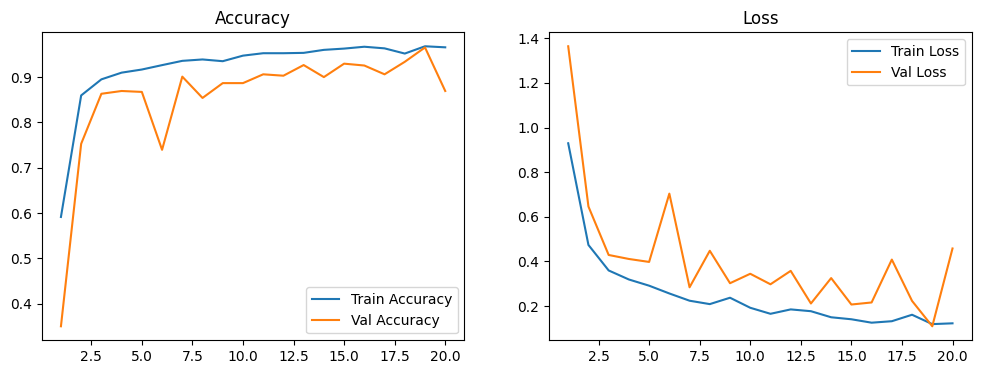

Final Training Accuracy: 0.9656
Final Validation Accuracy: 0.8693
Final Training Loss: 0.1222
Final Validation Loss: 0.4577


In [ ]:
import matplotlib.pyplot as plt

# Extract metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot metrics
#Kitne epochs train kiye the, uska range bana diya — jaise [1, 2, ..., 20]
#Ye X-axis ke liye chahiye hoga graph banate waqt.
epochs_range = range(1, len(acc) + 1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend(); plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(); plt.title('Loss')
plt.show()

# Print final values
print(f"Final Training Accuracy: {acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")
print(f"Final Training Loss: {loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")


#Image Prediction Visualization (with true labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


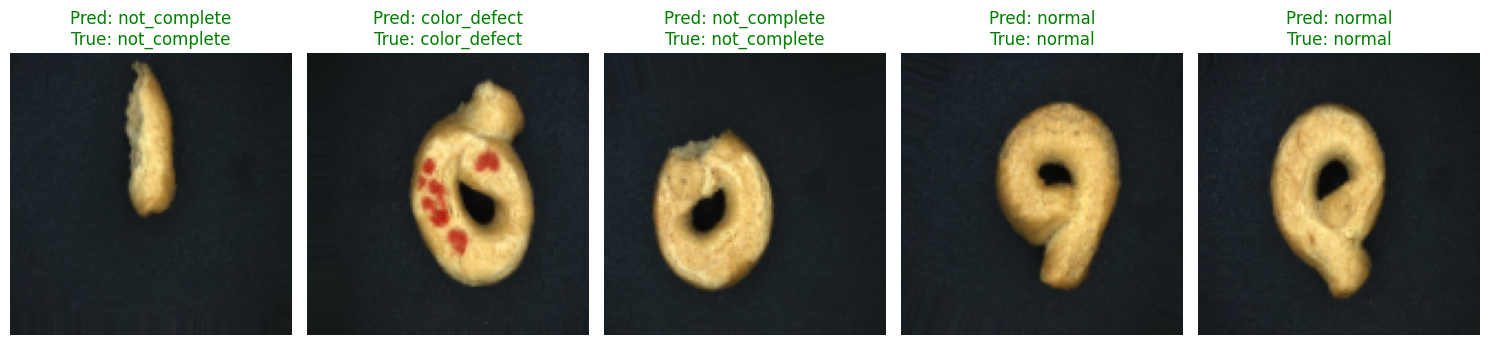

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, generator, class_names, num_images=5):
    #  Validation data se ek batch uthaya (maan le 32 images).
    #images: woh images hain
    #labels: unka actual answer (true class)
    images, labels = next(generator)
    #In images ka prediction karo bhai.
    predictions = model.predict(images)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        pred = class_names[pred_classes[i]]
        true = class_names[true_classes[i]]
        color = 'green' if pred == true else 'red'
        plt.title(f"Pred: {pred}\nTrue: {true}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
visualize_predictions(model, val_generator, class_names, num_images=5)


<h2>Segmentation Method</h2>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset extracted!
Total samples found: 884


100%|██████████| 884/884 [00:07<00:00, 123.22it/s]


✅ Data loaded and preprocessed!


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │        448 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 128, 128,  │      2,320 │ conv2d_22[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 64, 64,    │      9,248 │ conv2d_24[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_26[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 64, 64,    │      8,224 │ conv2d_27[0][0]   │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_25[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 64, 64,    │     18,464 │ concatenate_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 64, 64,    │      9,248 │ conv2d_28[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_5  │ (None, 128, 128,  │      2,064 │ conv2d_29[0][0]   │
│ (Conv2DTranspose)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 32)               │            │ conv2d_23[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 128, 128,  │      4,624 │ concatenate_5[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 128, 128,  │      2,320 │ conv2d_30[0][0] 

 Total params: 117,041 (457.19 KB)

 Trainable params: 117,041 (457.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.1209 - dice_coefficient: 0.1883 - iou: 0.1047 - loss: 0.8117 - val_accuracy: 0.6117 - val_dice_coefficient: 0.2306 - val_iou: 0.1309 - val_loss: 0.7704 - learning_rate: 0.0010
Epoch 2/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.6113 - dice_coefficient: 0.2635 - iou: 0.1535 - loss: 0.7268 - val_accuracy: 0.6437 - val_dice_coefficient: 0.3204 - val_iou: 0.1914 - val_loss: 0.6836 - learning_rate: 0.0010
Epoch 3/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.6414 - dice_coefficient: 0.3508 - iou: 0.2143 - loss: 0.6551 - val_accuracy: 0.6675 - val_dice_coefficient: 0.3368 - val_iou: 0.2034 - val_loss: 0.6686 - learning_rate: 0.0010
Epoch 4/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.6452 - dice_coefficient: 0.3032 - iou: 0.1809 - loss: 0.6868 - val_accuracy: 0.6783 - val_dice_coefficient: 0.3652 - val_iou: 0.2242 - val_loss: 0.6403 - learning_rate: 0.0010
Epoch 5/80
44/44 ━━━━━━━━━━━━━━━

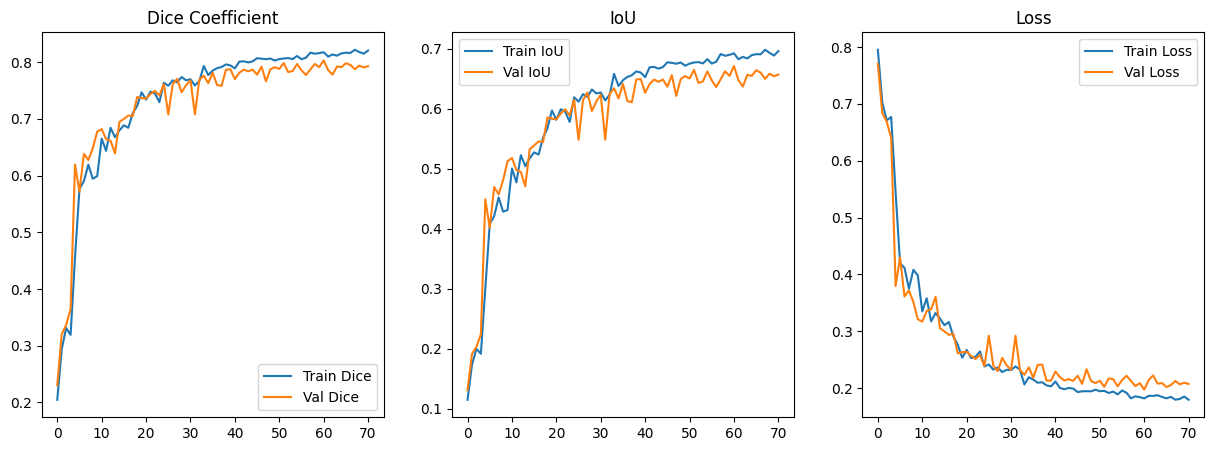

Final Train Dice: 0.8206
Final Val Dice:   0.7929
Final Train IoU:  0.6963
Final Val IoU:    0.6572
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


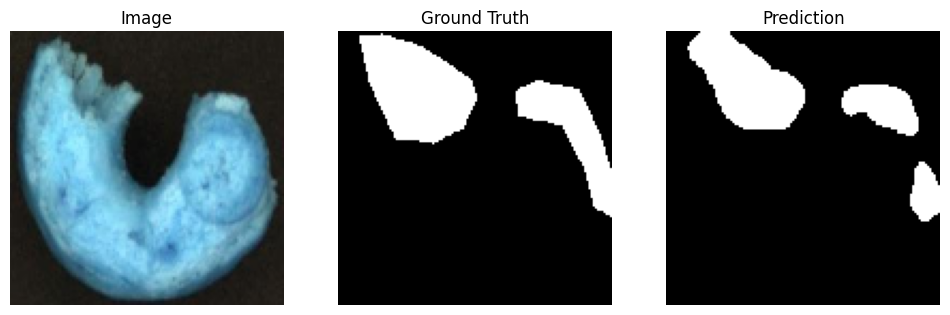

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


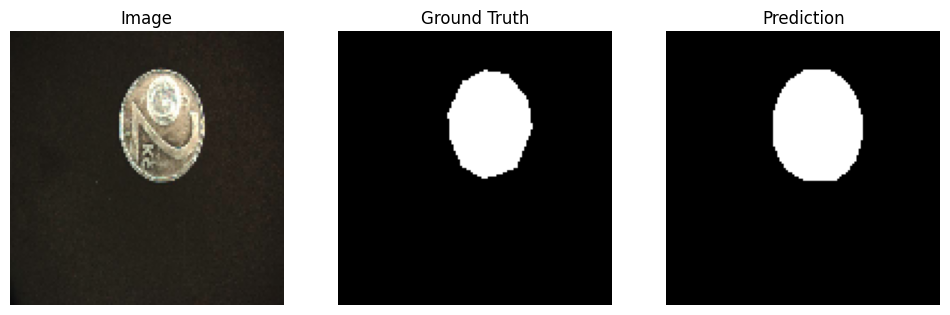

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


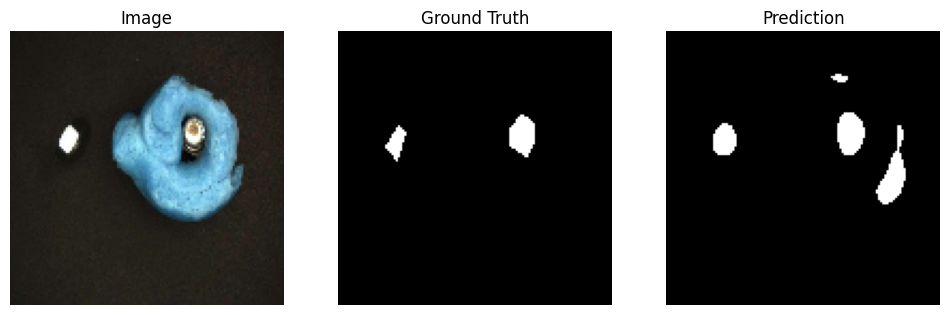

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


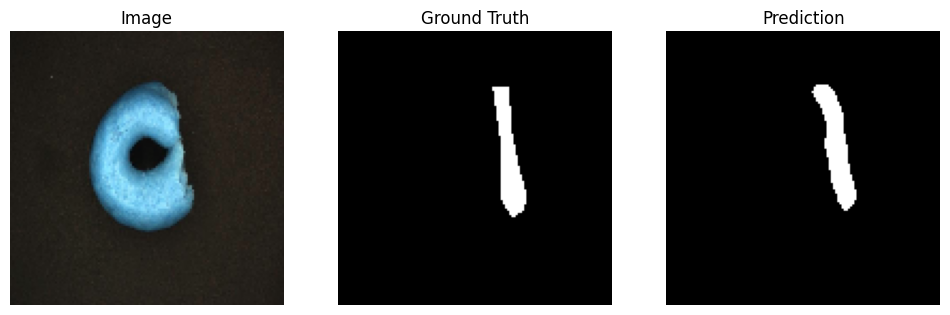

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


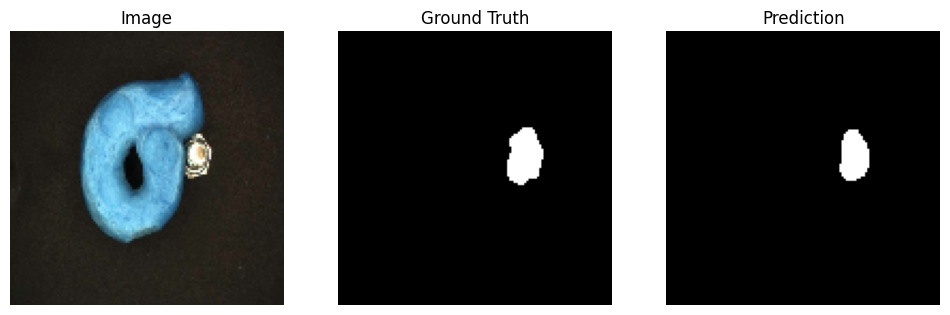

In [ ]:
# --------------------------------------------
# 1. Mount Google Drive and Extract the Dataset
# --------------------------------------------
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/MyProjects/Biscuit_Project/Masks.zip'
extract_path = '/content/Masks'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted!")

# --------------------------------------------
# 2. Load Image-Mask Pairs from Nested Folders
# --------------------------------------------
import cv2
import numpy as np
from tqdm import tqdm

image_paths = []
mask_paths = []

for root, dirs, files in os.walk(extract_path):
    if 'img.png' in files and 'label.png' in files:
        image_paths.append(os.path.join(root, 'img.png'))
        mask_paths.append(os.path.join(root, 'label.png'))

print(f"Total samples found: {len(image_paths)}")

# --------------------------------------------
# 3. Preprocess Images & Masks
# --------------------------------------------
from sklearn.model_selection import train_test_split

IMG_HEIGHT, IMG_WIDTH = 128, 128

X = []
Y = []

for img_path, mask_path in tqdm(zip(image_paths, mask_paths), total=len(image_paths)):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    #Normalize pixel values from [0–255] to [0–1]
    img = img / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    #Binarize: all non-zero pixels become 1
    mask = np.where(mask > 0, 1, 0)
    mask = np.expand_dims(mask, axis=-1)

    X.append(img)
    Y.append(mask)

X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.float32)
#Split into 80% training, 20% validation.
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print("✅ Data loaded and preprocessed!")

# --------------------------------------------
# 4. Define Dice and IoU Metrics & Loss
# --------------------------------------------
import tensorflow as tf

#Dice coefficient: Measures overlap between predicted and true mask.
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

#Intersection over Union (IoU): Another way to measure segmentation accuracy.
def iou(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

#Dice Loss: Loss function to optimize segmentation performance.
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# --------------------------------------------
# 5. Build U-Net Model
# --------------------------------------------
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model

def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder Features extract karta hai from raw image
    c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, 3, activation='relu', padding='same')(c1)
    #se size half ho jata hai Yeh dimensionality reduce karta hai aur important
    #features pick karta hai
    p1 = MaxPooling2D((2, 2))(c1)

    #Network deeper ho raha hai → zyada complex features learn karta hai
    c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(64, 3, activation='relu', padding='same')(c3)

    # Decoder Segmentation mask banana
    u1 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(c3)
    u1 = concatenate([u1, c2])
    c4 = Conv2D(32, 3, activation='relu', padding='same')(u1)
    c4 = Conv2D(32, 3, activation='relu', padding='same')(c4)

    u2 = Conv2DTranspose(16, 2, strides=(2, 2), padding='same')(c4)
    u2 = concatenate([u2, c1])
    c5 = Conv2D(16, 3, activation='relu', padding='same')(u2)
    c5 = Conv2D(16, 3, activation='relu', padding='same')(c5)

    outputs = Conv2D(1, 1, activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    return model

model = build_unet((IMG_HEIGHT, IMG_WIDTH, 3))
model.compile(optimizer='adam',
              loss=dice_loss,
              metrics=[dice_coefficient, iou, 'accuracy'])
model.summary()

# --------------------------------------------
# 6. Data Generators for Training
# --------------------------------------------
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.05,
                                   height_shift_range=0.05,
                                   shear_range=0.05,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

mask_datagen = ImageDataGenerator(rotation_range=10,
                                 width_shift_range=0.05,
                                 height_shift_range=0.05,
                                 shear_range=0.05,
                                 zoom_range=0.1,
                                 horizontal_flip=True,
                                 fill_mode='nearest')

batch_size = 16

image_generator = image_datagen.flow(X_train, batch_size=batch_size, seed=42)
mask_generator = mask_datagen.flow(Y_train, batch_size=batch_size, seed=42)

def combined_generator(image_gen, mask_gen):
    while True:
        X_batch = next(image_gen)
        Y_batch = next(mask_gen)
        yield X_batch, Y_batch

train_generator = combined_generator(image_generator, mask_generator)

# --------------------------------------------
# 7. Train Model
# --------------------------------------------
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=(X_val, Y_val),
    epochs=80,
    callbacks=[earlystop, reduce_lr]
)

# --------------------------------------------
# 8. Plot Metrics
# --------------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(history.history['dice_coefficient'], label='Train Dice')
plt.plot(history.history['val_dice_coefficient'], label='Val Dice')
plt.legend()
plt.title('Dice Coefficient')

plt.subplot(1,3,2)
plt.plot(history.history['iou'], label='Train IoU')
plt.plot(history.history['val_iou'], label='Val IoU')
plt.legend()
plt.title('IoU')

plt.subplot(1,3,3)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

print(f"Final Train Dice: {history.history['dice_coefficient'][-1]:.4f}")
print(f"Final Val Dice:   {history.history['val_dice_coefficient'][-1]:.4f}")
print(f"Final Train IoU:  {history.history['iou'][-1]:.4f}")
print(f"Final Val IoU:    {history.history['val_iou'][-1]:.4f}")

# --------------------------------------------
# 9. Visualize Predictions
# --------------------------------------------
def show_predictions(num=5):
    for i in range(num):
        idx = np.random.randint(0, len(X_val))
        img = X_val[idx]
        true_mask = Y_val[idx].squeeze()
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0].squeeze()
        pred_mask = (pred_mask > 0.5).astype(np.uint8)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Prediction")
        plt.axis('off')

        plt.show()

show_predictions(num=5)
